In [68]:
import pandas as pd
import requests
from bs4 import BeautifulSoup # analizar datos estructurados e interactuar con html
import folium # para visualización de mapas
from geopy.geocoders import Nominatim # para obtener latitud y longitud de un lugar dado
import numpy as np

# Obtain Data - Webscraping,  Join Data and Data Cleaning 

In [69]:
# función para extraer los datos necesarios de la página web y realizar la limpieza necesaria explicada en el archivo Obtain_Data_Webscraping.ipynb y Join_Data.ipynb
def Final_Data():
    url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' # url de pagina web
    page = requests.get(url) # extraer el contenido html
    soup = BeautifulSoup(page.content, "html.parser") # para hacer mas manejable las búsquedas
    tbody = soup.find("tbody")
    PC = []
    Borough = []
    for i in range(len(tbody.find_all('tr'))):
        for j in range(len(tbody.find_all("tr")[i].find_all('td'))):
            if tbody.find_all("tr")[i].find_all('td')[j].find('span').text == 'Not assigned':
                bij = None
                b = None
            else:
                bij = tbody.find_all("tr")[i].find_all('td')[j].find('span').text
            Borough.append(bij)
            pcij = tbody.find_all("tr")[i].find_all('td')[j].find('b').text
            PC.append(pcij)

    Toronto_City = pd.DataFrame({'Postal Code': PC,'Borough and Neighborhood':Borough})
    Toronto_City.dropna(inplace=True) # Eliminar registros vacios
    # dividir la columna por estos caracteres ()
    Borough_and_Neighborhood = Toronto_City["Borough and Neighborhood"].str.split('[()]',expand=True)
    # Unir columnas: 1 y 2, ya que en la columna 2 encontramos información necesaria para la columna 1
    Borough_and_Neighborhood[1] = Borough_and_Neighborhood[1].str.cat(Borough_and_Neighborhood[2],sep =' ')
    # eliminar columnas y reemplazar caracteres 
    Borough_and_Neighborhood.drop(columns=[2,4],inplace=True)
    Borough_and_Neighborhood[1] = Borough_and_Neighborhood[1].str.replace('/',',')
    # Unir columnas y reemplazar valores vacíos
    Borough_and_Neighborhood[1] = Borough_and_Neighborhood[1].str.cat(Borough_and_Neighborhood[3],sep =',',na_rep='-')
    # reemplazamos caracteres y eliminamos columnas
    Borough_and_Neighborhood[1]= Borough_and_Neighborhood[1].str.replace(',-','')
    Borough_and_Neighborhood.drop(columns=[3],inplace=True)
    # Cambiar el nombre de una columna
    Borough_and_Neighborhood.rename(columns = {0:"Borough",1:"Neighborhood"},inplace=True)
    # Concatenamos 2 dataframes
    Dataset = pd.concat([Toronto_City['Postal Code'], Borough_and_Neighborhood], axis=1)
    #leer dataframe de datos geospaciales
    Geospatial_Cordinates=pd.read_csv('https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv')
    # Union de columnas a un dataframen
    Dataset = Dataset.join(Geospatial_Cordinates.set_index('Postal Code'),on='Postal Code')
    # Eliminar un registro
    indexdrop = Dataset[Dataset['Borough']=='MississaugaCanada Post Gateway Processing Centre'].index
    Dataset.drop(indexdrop , inplace=True)
    # Reemplazar valores dentro de una columna
    Dataset.replace({'Borough': {
    'Central Toronto':'Downtown Toronto',
    'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
    "Queen's Park":"Downtown Toronto",
    'East Toronto':'East York',
    'East TorontoBusiness reply mail Processing Centre969 Eastern':'East York',
    'East YorkEast Toronto':'East York',
    'EtobicokeNorthwest':'Etobicoke',
    'West Toronto':'York',
    }},inplace=True)
    # Modificamos el indice
    Dataset.reset_index(drop=True,inplace=True)
    return Dataset

In [70]:
Dataset = Final_Data()
Dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494


# Exploratory Data Analysis

In [71]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Postal Code   102 non-null    object 
 1   Borough       102 non-null    object 
 2   Neighborhood  102 non-null    object 
 3   Latitude      102 non-null    float64
 4   Longitude     102 non-null    float64
dtypes: float64(2), object(3)
memory usage: 4.1+ KB


In [72]:
# Frecuencia de barrios por municipios
Dataset.groupby('Borough').size().sort_values(ascending=False)

Borough
Downtown Toronto    28
North York          24
Scarborough         17
Etobicoke           12
York                11
East York           10
dtype: int64

In [73]:
# Dirección que queremos obtener las coordenadas geográficas
address = 'Toronto, Ontario'
# Obtención de las coordenadas geográficas
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [74]:
# Configuración del color para los municipios
import matplotlib.cm as cm
import matplotlib.colors as colors
colors_array = cm.rainbow(np.linspace(0, 1, len(Dataset['Borough'].unique())))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Gererar mapa de los vecindarios en los municipios correspondientes
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.5)
for lat, lng, borough, neighborhood in zip(Dataset['Latitude'], Dataset['Longitude'], Dataset['Borough'], Dataset['Neighborhood']):
    html = f'''
        <strong>Neighborhood(s):</strong> {neighborhood} <br>
        <strong>Borough:</strong> {borough}
        '''
    iframe = folium.IFrame(html, width=500, height=100)
    popup = folium.Popup(iframe,max_width=1000)        
    indice_color = Dataset['Borough'].unique().tolist().index(borough)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=popup,
        color='#000000',
        fill=True,
        fill_color=rainbow[indice_color],
        fill_opacity=0.7).add_to(map_toronto)  
map_toronto

## Obtain information of places with Foursquare

In [75]:
#  Explorar lugares dentro de cada vecindario
def getNearbyVenues(names_boroughs,names_neighborhoods,latitudes,longitudes,radius=500,limit=50):
    
    # credenciales
    headers = {
        "accept": "application/json",
        "Authorization": "fsq3fEOiDbYgu1Dh6nPCkeTv+5Euf380F6c/C+dQ4uxP8V8="
        }
    
    venues_list = []
    
    for name_borough,name_neighborhood,lat, lng in zip(names_boroughs,names_neighborhoods,latitudes, longitudes):
        
        print(name_neighborhood)
        # crear la URL de solicitud de API
        url = "https://api.foursquare.com/v3/places/search?ll={},{}&radius={}&limit={}".format(
            lat,
            lng,
            radius,
            limit)
            
        # solicitud GET
        results = requests.get(url,headers = headers).json()
        results = results['results']
        
        # regresa solo información relevante de cada sitio cercano
        for i in range(len(results)):
            if len(results[i]['categories'])== 0:
                venues_list.append([(
                    name_borough,
                    name_neighborhood,
                    lat, 
                    lng, 
                    results[i]['name'], 
                    results[i]['geocodes']['main']['latitude'], 
                    results[i]['geocodes']['main']['longitude'],
                    None
                )])
            else:
                venues_list.append([(
                    name_borough,
                    name_neighborhood, 
                    lat, 
                    lng, 
                    results[i]['name'], 
                    results[i]['geocodes']['main']['latitude'], 
                    results[i]['geocodes']['main']['longitude'],
                    results[i]['categories'][0]['name']
                )])
                
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                'Borough',
                'Neighborhood', 
                'Neighborhood Latitude', 
                'Neighborhood Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
    
    return(nearby_venues)

In [76]:
# Dataset con los lugares encontrados por vecindario
Dataset_Venues = getNearbyVenues(Dataset['Borough'],Dataset['Neighborhood'],Dataset['Latitude'],Dataset['Longitude'],radius=500,limit=50)

Parkwoods 
Victoria Village 
Regent Park , Harbourfront 
Lawrence Manor , Lawrence Heights 
Ontario Provincial Government 
Islington Avenue 
Malvern , Rouge 
Don Mills North
Parkview Hill , Woodbine Gardens 
Garden District, Ryerson 
Glencairn 
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale 
Rouge Hill , Port Union , Highland Creek 
Don Mills South,Flemingdon Park
Woodbine Heights 
St. James Town 
Humewood-Cedarvale 
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood 
Guildwood , Morningside , West Hill 
The Beaches 
Berczy Park 
Caledonia-Fairbanks 
Woburn 
Leaside 
Central Bay Street 
Christie 
Cedarbrae 
Hillcrest Village 
Bathurst Manor , Wilson Heights , Downsview North 
Thorncliffe Park 
Richmond , Adelaide , King 
Dufferin , Dovercourt Village 
Scarborough Village 
Fairview , Henry Farm , Oriole 
Northwood Park , York University 
The Danforth  East 
Harbourfront East , Union Station , Toronto Islands 
Little Portugal , Trinity 
Kennedy P

In [77]:
print(Dataset_Venues.shape)
Dataset_Venues.head()

(4231, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.754751,-79.328439,Park
1,North York,Parkwoods,43.753259,-79.329656,Ace Pump Sales & Svc Ltd,43.754539,-79.329812,None
2,North York,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751562,-79.332152,Swimming Pool
3,North York,Parkwoods,43.753259,-79.329656,Adrienne Kerr Freelance Editing,43.752960,-79.332232,None
4,North York,Parkwoods,43.753259,-79.329656,Variety Store,43.751978,-79.333389,Food and Beverage Retail


In [78]:
len(Dataset_Venues['Neighborhood'].unique())

102

In [79]:
# Cantidad de registros duplicados 
print("La cantidad de registros duplicados es:",len(Dataset_Venues[Dataset_Venues.duplicated()]))

La cantidad de registros duplicados es: 2


In [80]:
# Ver registros duplicados
Dataset_Venues[Dataset_Venues.duplicated()]

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
999,East York,Leaside,43.709060,-79.363452,Local Public Eatery,43.709977,-79.363491,Restaurant
1911,Scarborough,"Golden Mile , Clairlea , Oakridge",43.711112,-79.284577,Columbia Sportswear Co,43.710993,-79.284594,Clothing Store


In [81]:
# Eliminar registros duplicados y resetear el índice
Dataset_Venues.drop_duplicates(inplace=True,ignore_index=True)
Dataset_Venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4229 entries, 0 to 4228
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Borough                 4229 non-null   object 
 1   Neighborhood            4229 non-null   object 
 2   Neighborhood Latitude   4229 non-null   float64
 3   Neighborhood Longitude  4229 non-null   float64
 4   Venue                   4229 non-null   object 
 5   Venue Latitude          4229 non-null   float64
 6   Venue Longitude         4229 non-null   float64
 7   Venue Category          3907 non-null   object 
dtypes: float64(4), object(4)
memory usage: 264.4+ KB


In [82]:
len(Dataset_Venues['Neighborhood'].unique())

102

In [83]:
# Eliminar los registros con categorias Null
Dataset_Venues_Delete_null = Dataset_Venues.dropna().reset_index(drop=True)
#Dataset_Venues.dropna(inplace=True)

In [84]:
Dataset_Venues_Delete_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3907 entries, 0 to 3906
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Borough                 3907 non-null   object 
 1   Neighborhood            3907 non-null   object 
 2   Neighborhood Latitude   3907 non-null   float64
 3   Neighborhood Longitude  3907 non-null   float64
 4   Venue                   3907 non-null   object 
 5   Venue Latitude          3907 non-null   float64
 6   Venue Longitude         3907 non-null   float64
 7   Venue Category          3907 non-null   object 
dtypes: float64(4), object(4)
memory usage: 244.3+ KB


In [85]:
# Frecuencia de lugares registrados  por municipio
Borough_Venues_Frecuency = Dataset_Venues_Delete_null.groupby('Borough').size()
Borough_Venues_Frecuency

Borough
Downtown Toronto    1207
East York            448
Etobicoke            369
North York           838
Scarborough          581
York                 464
dtype: int64

In [86]:
len(Dataset_Venues_Delete_null['Neighborhood'].unique())

102

In [87]:
# Frecuencia de lugares registrados  por municipio y vecindario
Neighborhood_Borough_Venues_Frecuency = Dataset_Venues_Delete_null.groupby('Borough')['Neighborhood'].value_counts()
Neighborhood_Borough_Venues_Frecuency

Borough           Neighborhood                    
Downtown Toronto  Berczy Park                         50
                  Central Bay Street                  50
                  Church and Wellesley                50
                  Commerce Court , Victoria Hotel     50
                  Enclave of M5E                      50
                                                      ..
York              Parkdale , Roncesvalles             46
                  Weston                              42
                  Runnymede , The Junction North      38
                  Caledonia-Fairbanks                 25
                  Humewood-Cedarvale                  24
Name: Neighborhood, Length: 102, dtype: int64

In [88]:
# Frecuencia de lugares registrados por municipio , vecindario y nombre del lugar
Neighborhoods_Frecuency = Dataset_Venues_Delete_null.groupby(['Borough','Neighborhood'])['Venue'].value_counts()
Neighborhoods_Frecuency

Borough           Neighborhood  Venue                               
Downtown Toronto  Berczy Park   Tim Hortons                             2
                                Alexandro's World Famous Gyros          1
                                Balzacs Coffee Ltd                      1
                                Bar Cathedral                           1
                                Berczy Park                             1
                                                                       ..
York              Weston        Tokyo Shiatsu Clinic                    1
                                Toni's Place                            1
                                Travelex Currency Svc                   1
                                Wasserman Sports & Entertainment Inc    1
                                eGroup                                  1
Name: Venue, Length: 3857, dtype: int64

In [89]:
# Frecuencia de Categorías
Category_Frecuency = Dataset_Venues_Delete_null.groupby('Venue Category').size().sort_values(ascending=False)
Category_Frecuency

Venue Category
Business and Professional Services    112
Clothing Store                         90
Hair Salon                             89
General Contractor                     87
Café                                   79
                                     ... 
Disabled Persons Service                1
Plastics Supplier                       1
Poke Restaurant                         1
Polish Restaurant                       1
Youth Organization                      1
Length: 427, dtype: int64

In [90]:
# Frecuencia de lugares por municipios y categorias
Borough_Category_Frecuency = Dataset_Venues_Delete_null.groupby('Borough')['Venue Category'].value_counts()
Borough_Category_Frecuency

Borough           Venue Category               
Downtown Toronto  Café                             52
                  Restaurant                       40
                  Cafes, Coffee, and Tea Houses    36
                  Coffee Shop                      35
                  Pizzeria                         29
                                                   ..
York              Tire Repair Shop                  1
                  Towing Service                    1
                  Travel and Transportation         1
                  Tree Service                      1
                  Women's Store                     1
Name: Venue Category, Length: 1227, dtype: int64

In [91]:
# Frecuencia de lugares por categoria y municipios
Neighborhood_Borough_Category_Frecuency = Dataset_Venues_Delete_null.groupby(['Borough','Neighborhood'])['Venue Category'].value_counts()
len(Neighborhood_Borough_Category_Frecuency[Neighborhood_Borough_Category_Frecuency == 1])

2405

In [92]:
Neighborhood_Borough_Category_Frecuency

Borough           Neighborhood  Venue Category               
Downtown Toronto  Berczy Park   Beer Bar                         2
                                Cafes, Coffee, and Tea Houses    2
                                Coffee Shop                      2
                                Drugstore                        2
                                Farmers' Market                  2
                                                                ..
York              Weston        Restaurant                       1
                                Shoe Store                       1
                                Telecommunication Service        1
                                Tire Repair Shop                 1
                                Travel and Transportation        1
Name: Venue Category, Length: 2994, dtype: int64

In [93]:
# Cantidad de categorias registradas en todos los lugares
print('There are {} uniques categories.'.format(len(Dataset_Venues_Delete_null['Venue Category'].unique())))

There are 427 uniques categories.


In [94]:
Neighborhood_VenueCategory = Dataset_Venues_Delete_null.groupby('Neighborhood')['Venue Category'].value_counts()
Neighborhood_VenueCategory

Neighborhood      Venue Category                                        
Agincourt         Clothing Store                                            5
                  Business and Professional Services                        3
                  Painter                                                   3
                  Real Estate Agency                                        3
                  Furniture and Home Store                                  2
                                                                           ..
York Mills West   Physical Therapy Clinic                                   1
                  Professional Cleaning Service                             1
                  Security and Safety                                       1
                  Shipping, Freight, and Material Transportation Service    1
                  Tennis Court                                              1
Name: Venue Category, Length: 2994, dtype: int64

In [95]:
# Categorías en un solo lugar asignado
name_categorias_size_1 = Category_Frecuency[Category_Frecuency==1].index.values.tolist()
len(name_categorias_size_1)

123

In [96]:
# Dataset con registros eliminados donde la categoria esta en un solo lugar
Dataset_Venues_drop_categories_size_1 = Dataset_Venues_Delete_null.drop(Dataset_Venues_Delete_null.index[Dataset_Venues_Delete_null['Venue Category'].isin(name_categorias_size_1)])
Dataset_Venues_drop_categories_size_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3784 entries, 0 to 3906
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Borough                 3784 non-null   object 
 1   Neighborhood            3784 non-null   object 
 2   Neighborhood Latitude   3784 non-null   float64
 3   Neighborhood Longitude  3784 non-null   float64
 4   Venue                   3784 non-null   object 
 5   Venue Latitude          3784 non-null   float64
 6   Venue Longitude         3784 non-null   float64
 7   Venue Category          3784 non-null   object 
dtypes: float64(4), object(4)
memory usage: 266.1+ KB


In [97]:
# Cantidad de categorias únicas registradas en todos los lugares
print('There are {} uniques categories.'.format(len(Dataset_Venues_drop_categories_size_1['Venue Category'].unique())))

There are 304 uniques categories.


In [98]:
# Cantidad de vecindarios únicos en el dataset
len(Dataset_Venues_drop_categories_size_1['Neighborhood'].unique())

102

In [99]:
# codificación
manhattan_onehot = pd.get_dummies(Dataset_Venues_drop_categories_size_1[['Venue Category']], prefix="", prefix_sep="")
manhattan_onehot

,ATM,Accounting and Bookkeeping Service,Advertising Agency,African Restaurant,American Restaurant,Antique Store,Architecture Firm,Art Gallery,Art Restoration Service,Arts and Crafts Store,...,Video Games Store,Video Store,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Website Designer,Wholesaler,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3904,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# Añadir 2 columnas al dataset anterior
One_Hot_Dataset = pd.concat([Dataset_Venues_drop_categories_size_1[['Borough','Neighborhood']],manhattan_onehot], axis=1)
One_Hot_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3784 entries, 0 to 3906
Columns: 306 entries, Borough to Yoga Studio
dtypes: object(2), uint8(304)
memory usage: 1.2+ MB


In [101]:
# Ver dimensión del nuevo dataframe
One_Hot_Dataset.shape

(3784, 306)

In [102]:
# Promedio de la cantidad de lugares según la categoría
Dataset_grouped = One_Hot_Dataset.groupby(['Borough','Neighborhood']).mean().reset_index()
Dataset_grouped.info()
Dataset_grouped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Columns: 306 entries, Borough to Yoga Studio
dtypes: float64(304), object(2)
memory usage: 244.0+ KB


,Borough,Neighborhood,ATM,Accounting and Bookkeeping Service,Advertising Agency,African Restaurant,American Restaurant,Antique Store,Architecture Firm,Art Gallery,...,Video Games Store,Video Store,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Website Designer,Wholesaler,Wine Bar,Women's Store,Yoga Studio
0,Downtown Toronto,Berczy Park,0.0,0.0,0.000000,0.02,0.020000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Downtown Toronto,"CN Tower , King and Spadina , Railway Lands , ...",0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Downtown Toronto,Central Bay Street,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Downtown Toronto,Christie,0.0,0.0,0.021739,0.00,0.021739,0.021739,0.021739,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.021739,0.0,0.0
4,Downtown Toronto,Church and Wellesley,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [103]:
# Estadísticos descriptivos
Dataset_grouped.describe()

,ATM,Accounting and Bookkeeping Service,Advertising Agency,African Restaurant,American Restaurant,Antique Store,Architecture Firm,Art Gallery,Art Restoration Service,Arts and Crafts Store,...,Video Games Store,Video Store,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse / Wholesale Store,Website Designer,Wholesaler,Wine Bar,Women's Store,Yoga Studio
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.002546,0.008683,0.004812,0.000592,0.004081,0.001276,0.006557,0.003422,0.000417,0.002041,...,0.000417,0.000650,0.002108,0.001632,0.000869,0.003529,0.000679,0.001026,0.001265,0.000461
std,0.009836,0.022536,0.012795,0.003419,0.009250,0.005975,0.020917,0.014231,0.002967,0.013807,...,0.002965,0.003754,0.008132,0.007964,0.005379,0.013698,0.005106,0.006813,0.005739,0.003279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.066667,0.125000,0.068966,0.020408,0.041667,0.043478,0.125000,0.125000,0.021739,0.125000,...,0.021277,0.023256,0.061224,0.062500,0.045455,0.100000,0.046512,0.062500,0.037037,0.023810


In [104]:
# Rango de las variables de ambos datasets
print(f"Peak to Peak range by column of Dataset_gruped:{np.ptp(Dataset_grouped.iloc[:,2:306].values,axis=0)}")  

Peak to Peak range by column of Dataset_gruped:[0.06666667 0.125      0.06896552 0.02040816 0.04166667 0.04347826
 0.125      0.125      0.02173913 0.125      0.04545455 0.0625
 0.125      0.0625     0.34042553 0.02272727 0.05263158 0.02325581
 0.11111111 0.04545455 0.08163265 0.09756098 0.03125    0.0625
 0.04545455 0.08333333 0.03225806 0.04255319 0.05       0.04651163
 0.04       0.04347826 0.02702703 0.0212766  0.02941176 0.04545455
 0.04545455 0.04347826 0.06       0.02325581 0.1875     0.1875
 0.02631579 0.12       0.12244898 0.0212766  0.05263158 0.2826087
 0.06976744 0.02222222 0.02325581 0.03225806 0.10344828 0.08333333
 0.04761905 0.02325581 0.02222222 0.02325581 0.03225806 0.125
 0.06122449 0.0625     0.34883721 0.0625     0.08163265 0.04
 0.0212766  0.04       0.11111111 0.125      0.03448276 0.02325581
 0.10526316 0.03703704 0.06451613 0.06896552 0.02439024 0.02173913
 0.02173913 0.05405405 0.02631579 0.04545455 0.08       0.05
 0.06382979 0.04347826 0.02325581 0.0625     

In [105]:
# 5 lugares mas frecuentes por vecindario
num_top_venues = 5

for hood in Dataset_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Dataset_grouped[Dataset_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park ----
                           venue  freq
0                      Drugstore  0.04
1                    Coffee Shop  0.04
2               Sushi Restaurant  0.04
3  Cafes, Coffee, and Tea Houses  0.04
4                       Beer Bar  0.04


----CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport ----
                        venue  freq
0      Landmarks and Outdoors  0.17
1             Harbor / Marina  0.17
2    Home Improvement Service  0.17
3       Sports and Recreation  0.17
4  Property Management Office  0.17


----Central Bay Street ----
                           venue  freq
0  Cafes, Coffee, and Tea Houses  0.12
1                           Deli  0.08
2                    Coffee Shop  0.08
3                       Pizzeria  0.04
4                          Diner  0.04


----Christie ----
                                venue  freq
0         Grocery Store / Supermarket  0.07
1              Automotive Repair 

In [106]:
# Función para devolver el top de las categorias mas registradas en los vecindarios
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [107]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Dataset_grouped['Neighborhood']

for ind in np.arange(Dataset_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dataset_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Drugstore,Coffee Shop,Sushi Restaurant,"Cafes, Coffee, and Tea Houses",Beer Bar,Farmers' Market,Night Club,Pub,Fish and Chips Shop,Restaurant
1,"CN Tower , King and Spadina , Railway Lands , ...",Landmarks and Outdoors,Harbor / Marina,Home Improvement Service,Sports and Recreation,Property Management Office,Sculpture Garden,New American Restaurant,Nail Salon,Music Venue,Music Store
2,Central Bay Street,"Cafes, Coffee, and Tea Houses",Deli,Coffee Shop,Pizzeria,Diner,Juice Bar,Fast Food Restaurant,Asian Restaurant,Thai Restaurant,Café
3,Christie,Grocery Store / Supermarket,Automotive Repair Shop,Business and Professional Services,Restaurant,Hardware Store,Hair Salon,Café,Electrician,General Contractor,Massage Clinic
4,Church and Wellesley,Hair Salon,Italian Restaurant,Restaurant,Thai Restaurant,Bubble Tea Shop,Clothing Store,Tattoo Parlor,Liquor Store,Diner,Dance Studio


# K-Means

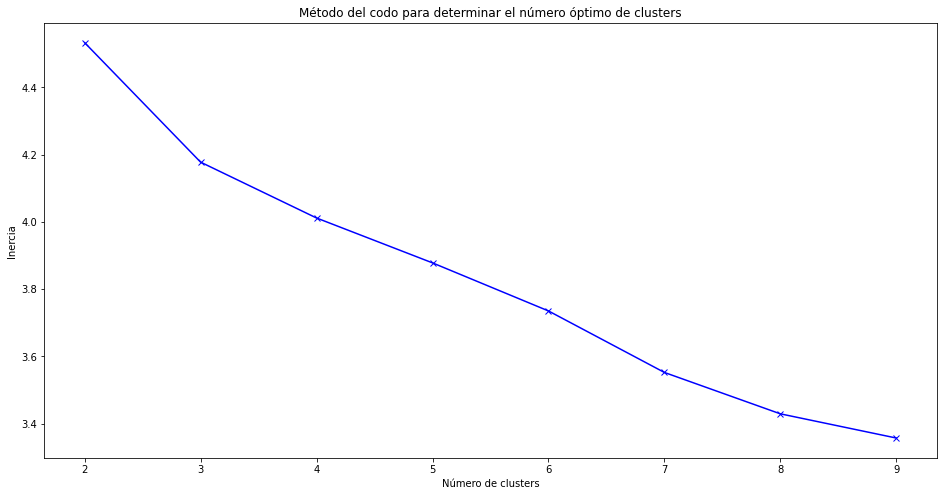

In [108]:
# Método del codo para determinar el número óptimo de clases

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cantidad_clusters = list(range(2, 10))
total_inertia = []

for n_clusters in cantidad_clusters:
    
    model = KMeans(n_clusters = n_clusters,random_state=0,max_iter=1000)
    model.fit(Dataset_grouped.iloc[:,2:306].values)
    
    inertia_model = model.inertia_
    total_inertia.append(inertia_model)
    
plt.figure(figsize=(16,8))
plt.plot(cantidad_clusters, total_inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.show()

In [109]:
# K-Means
# establecer el número de agrupaciones
kclusters = 4

# Eliminar 2 columnas del dataset
Dataset_grouped_clustering = Dataset_grouped.drop(['Borough','Neighborhood'], 1)

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Dataset_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

C:\Users\MAX\AppData\Local\Temp\ipykernel_23016\4175117802.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Dataset_grouped_clustering = Dataset_grouped.drop(['Borough','Neighborhood'], 1)


array([0, 3, 0, 1, 0, 0, 0, 0, 0, 0])

In [110]:
# añadir etiquetas de cluster
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Berczy Park,Drugstore,Coffee Shop,Sushi Restaurant,"Cafes, Coffee, and Tea Houses",Beer Bar,Farmers' Market,Night Club,Pub,Fish and Chips Shop,Restaurant
1,3,"CN Tower , King and Spadina , Railway Lands , ...",Landmarks and Outdoors,Harbor / Marina,Home Improvement Service,Sports and Recreation,Property Management Office,Sculpture Garden,New American Restaurant,Nail Salon,Music Venue,Music Store
2,0,Central Bay Street,"Cafes, Coffee, and Tea Houses",Deli,Coffee Shop,Pizzeria,Diner,Juice Bar,Fast Food Restaurant,Asian Restaurant,Thai Restaurant,Café
3,1,Christie,Grocery Store / Supermarket,Automotive Repair Shop,Business and Professional Services,Restaurant,Hardware Store,Hair Salon,Café,Electrician,General Contractor,Massage Clinic
4,0,Church and Wellesley,Hair Salon,Italian Restaurant,Restaurant,Thai Restaurant,Bubble Tea Shop,Clothing Store,Tattoo Parlor,Liquor Store,Diner,Dance Studio


In [111]:
# Unión de 2 dataframe
Toronto_merged = Dataset

# juntar manhattan_grouped con manhattan_data 
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # revisar las ultimas columnas

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Business and Professional Services,Accounting and Bookkeeping Service,Park,Swimming Pool,Landscaper and Gardener,Community and Government,Health Food Store,Engineer,Audiovisual Service,Food and Beverage Retail
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Car Dealership,Print Store,General Contractor,Automotive Repair Shop,Media Agency,Organization,Bridal Store,Burger Joint,Business and Professional Services,Stadium
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0,Car Dealership,Bakery,Park,Restaurant,Furniture and Home Store,Italian Restaurant,Automotive Repair Shop,Coffee Shop,Music Venue,Gift Store
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Housewares Store,Business and Professional Services,"Cafes, Coffee, and Tea Houses",Cosmetics Store,Carpet and Flooring Contractor,Spa,Fashion Accessories Store,Furniture and Home Store,Night Club
4,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494,0,Coffee Shop,"Cafes, Coffee, and Tea Houses",Café,Deli,Bank,Italian Restaurant,Fried Chicken Joint,Hair Salon,Diner,Caterer


In [112]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [113]:
# Cantidad de vecindarios según cluster
Toronto_merged.groupby('Cluster Labels').size()

Cluster Labels
0    56
1    44
2     1
3     1
dtype: int64

In [114]:
Toronto_merged.groupby('Cluster Labels')['1st Most Common Venue'].value_counts()

Cluster Labels  1st Most Common Venue                  
0               Café                                        7
                Hair Salon                                  7
                Clothing Store                              6
                Restaurant                                  5
                Attorney / Law Office                       3
                Bank                                        3
                Drugstore                                   3
                Public and Social Service                   3
                Real Estate Agency                          2
                Accounting and Bookkeeping Service          1
                Bar                                         1
                Bookstore                                   1
                Business and Professional Services          1
                Cafes, Coffee, and Tea Houses               1
                Car Dealership                              1
              